In [1]:
import cv2
import h5py
import numpy as np
from matplotlib import pyplot as plt
from vcg_connectomics.data.augmentation import *

In [2]:
# Load Data
data_path = '/n/coxfs01/zudilin/research/mitoNet/data/file/snemi/'
image_path = data_path + 'img/train-input_df_150.h5'
label_path = data_path + 'label/train-labels.h5'
image = np.array(h5py.File(image_path, 'r')['main'])
label = np.array(h5py.File(label_path, 'r')['main'])
print(image.shape, image.ndim, image.dtype)
print(label.shape, label.ndim, label.dtype)

(100, 1024, 1024) 3 uint8
(100, 1024, 1024) 3 uint16


In [3]:
augmentor = Compose([Rotate(p=1.0),
                     Rescale(p=1.0),
                     Flip(p=0.0),
                     Elastic(alpha=10.0, p=1.0),
                     Grayscale()], 
                     input_size = (8,160,160))
print(augmentor.sample_size)

Sample size required for the augmentor: [  8 307 307]
[  8 307 307]


In [4]:
test_image = image[:8, :307, :307]/255.0
test_label = label[:8, :307, :307]

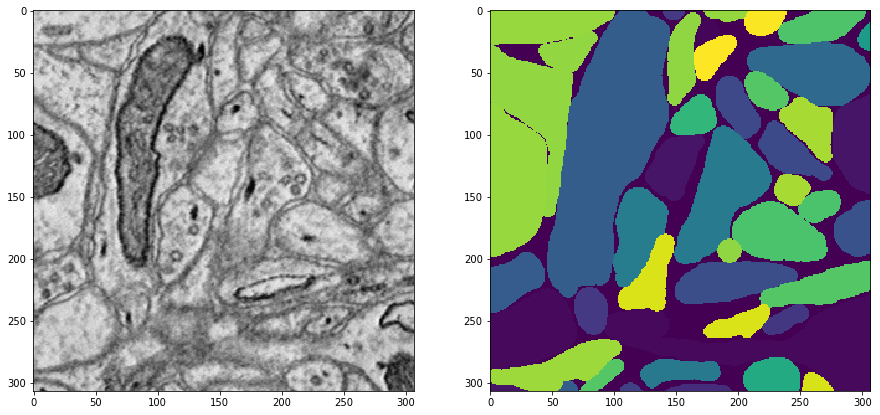

In [5]:
img_id = 5
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(test_image[img_id], cmap='gray')
plt.subplot(122)
plt.imshow(test_label[img_id])
plt.show()

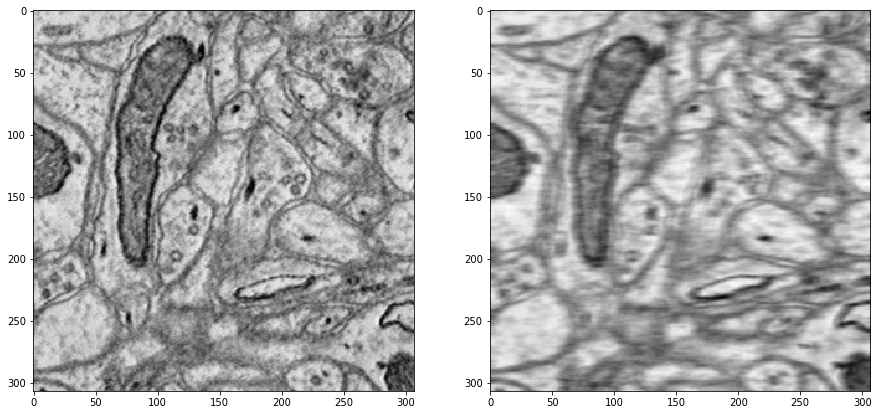

In [13]:
size = 9

# generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

# applying the kernel to the input image
output = cv2.filter2D(test_image[img_id], -1, kernel_motion_blur)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(test_image[img_id], cmap='gray')
plt.subplot(122)
plt.imshow(output, cmap='gray')
plt.show()

In [ ]:
data = {}
data['image']=test_image
data['label']=test_label
augmented = augmentor(data, random_state=np.random.RandomState(976))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(augmented['image'][5], cmap='gray')
plt.subplot(122)
plt.imshow(augmented['label'][5])
plt.show()

In [ ]:
from skimage.morphology import dilation,erosion
from skimage.filters import gaussian
temp = augmented['label'][5].copy()
for idx in np.unique(temp):
    if idx != 0:
        binary = (temp==idx).astype(np.uint8)
        for _ in range(2):
            binary = dilation(binary)
            binary = gaussian(binary, sigma=2, preserve_range=True)
            binary = dilation(binary)
            binary = (binary > 0.8).astype(np.uint8)
            
        temp[np.where(temp==idx)]=0
        temp[np.where(binary==1)]=idx
                         
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(erosion(dilation(augmented['label'][5].copy())))
plt.subplot(122)
plt.imshow(temp)
plt.show()